In [ ]:
%load_ext autoreload
%autoreload 

In [1]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
import PIL.Image
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
import time
from tf_conversions import posemath
import utils

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
rospy.init_node('notebook')
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/stereo/right/image_flipped', 'sensor_msgs/Image'],
 ['/dvrk/PSM3/goal_reached', 'std_msgs/Bool'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/ECM/position_cartesian_local_current',
  'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/PSM2/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM3/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/ECM/warning', 'std_msgs/String'],
 ['/dvrk/PSM3/manip_clutch', 'std_msgs/Bool'],
 ['/dvrk/PSM3/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnostic_msgs/

In [3]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_raw', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_raw', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

while left_image is None or right_image is None:
    print("left or right image not receieved")
    time.sleep(0.5)
    

left or right image not receieved


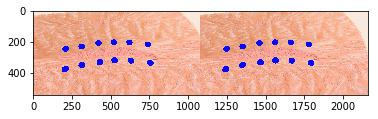

In [4]:
plt.imshow(np.hstack((left_image, right_image)))

In [5]:
tf_listener = tf.TransformListener()
time.sleep(1)
tf_listener.getFrameStrings()

/opt/ros/melodic/lib/python2.7/dist-packages/tf/listener.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(self._buffer.all_frames_as_yaml()) or {}


['PSM1_clip',
 'PSM2_clip',
 'PSM3_base',
 'simcamera',
 'PSM1_RCM',
 'PSM1',
 'PSM3_clip',
 'PSM2',
 'PSM3',
 'ECM_RCM',
 'ECM_base',
 'ECM',
 'PSM2_base',
 'PSM1_base',
 'PSM3_RCM',
 'PSM2_RCM']

In [6]:
#make sure you use the dvrk console to turn the robot on and home it before running this cell

#need to swap psm1 and 2 because they're not being registered properly
psm1 = dvrk.psm('PSM1')
psm2 = dvrk.psm('PSM2')
psm3 = dvrk.psm('PSM3')
ecm = dvrk.ecm('ECM')

psm1_suj = dvrk.suj('PSM1')
psm2_suj = dvrk.suj('PSM2')
psm3_suj = dvrk.suj('PSM3')
ecm_suj = dvrk.suj('ECM')

while ecm.get_current_position() == PyKDL.Frame() or ecm.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm1.get_current_position() == PyKDL.Frame() or psm1.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
    

In [18]:
from math import radians as r

# ECM_STARTING_JOINT_POS = np.asarray([-0.15669435,  0.17855662,  0.07069676,  0.17411496])
# ECM_STARTING_JOINT_POS = np.asarray([0.0615668 , 0.0523214 , 0.04854392, 0.15809197])
# ECM_STARTING_JOINT_POS = np.asarray([-0.14478268, -0.1293848 ,  0.00261061,  0.043541  ])

#3arm new params
# ECM_STARTING_JOINT_POS = np.asarray([-0.35, -0.1 ,  0.06,  0.03541  ])

# ECM_STARTING_JOINT_POS = np.asarray([0., -0.1 ,  0.05,  0.13541  ])

#pos without moving ecm suj
ECM_STARTING_JOINT_POS = np.asarray([-0.05, -0.12 ,  0.07,  0.04541  ]) #works without suj
ecm.move_joint(ECM_STARTING_JOINT_POS)

#ECM_STARTING_JOINT_POS = np.asarray([-0.05, -0.01 ,  0.1,  0.04541  ])
#ECM_STARTING_JOINT_POS = np.asarray([-0.05, -0.12 ,  0.05,  1.64541  ]) #tried for 90
#ECM_STARTING_JOINT_POS = np.asarray([-0.05, -0.2 ,  0.3,  0.04541  ]) #when we moved the ECM SUJ

sm1 = [ r(0.01), -1.29958212e+00,  1.70077503e+00,  1.39626339e-01,-2.23598790e-01]
psm1.move_joint(np.asarray(sm1))

#psm2_suj.move_joint(np.asarray(sm2))
sm2 = [ r(0.01), 1.29958212e+00,  -1.70077503e+00,  -1.39626339e-01,-2.23598790e-01]

#sm2=[[ 1.74532921e-04 , 1.34582071e+00, -1.680077503e+00, -1.39626339e-01, -4.23598790e-01]]
#psm1_suj.move_joint(np.asarray(sm1))
#sm2 = [ 0.1 ,        2.58308721, -2.79252672, -0.10471976, -0.61086524]

sm3 = [r(0.01), r(175), r(-145), r(60), r(0), r(20)] #this one works
psm3_suj.move_joint(np.asarray(sm3))

#psm2_suj.move_joint(np.asarray(sm2))


print("PSM1 SUJ position: ", psm1_suj.get_current_joint_position())
print("PSM2 SUJ position: ", psm2_suj.get_current_joint_position())
print("PSM3 SUJ position: ", psm3_suj.get_current_joint_position())

#sm2 = [r(0.01), r(195), r(-145), r(60), r(0), r(20)]
print(psm2_suj.get_current_position())


abs_pos must be an array of size 6
PSM1 SUJ position:  0.0
PSM2 SUJ position:  0.0
PSM3 SUJ position:  0.0
[[ 3.33067e-16,           1,           0;
           -1, 3.33067e-16,          -0;
           -0,           0,           1]
[      1.9501,   -0.101598,      0.9088]]


In [ ]:
#with ecm suj
cm = [ 0.75,    6.922771   ,-1.36780708 ,-0.23116999,0 ,0, 0]
ecm_suj.move_joint(np.asarray(cm))
ECM_STARTING_JOINT_POS = np.asarray([-0.01, -0.1 ,  0.23,  0.01541 ])
ecm.move_joint(ECM_STARTING_JOINT_POS)


sm1 = [0.05, -1.12958207607269287, 1.3400775073528289795, 0.43962633907794952, -0.7235987901687622]

#experimental sm2
sm2 = [ r(1), 1.282e+00,  -1.66503e+00,  -1.09626339e-01, -0.5235987901687622]
sm3 = [0.2, r(20), 2.3816503e+00, -10.09626339e-01, -0.56235987901687622]

In [46]:
from math import radians as r


sm1 = [r(0.01), -1.29958207607269287, 1.700775073528289795, 0.13962633907794952, -0.5235987901687622]

#Alaa's recommended quick fix - make psm 1 closer 
#works but hits tissue and 1 collision still sm2 = [ r(0.2), 1.29958212e+00,  -1.6050077503e+00,  -1.09626339e-01, -0.01]

#sm2 = [ 0.06, 1.23958212e+00,  -1.6050077503e+00,  -1.09626339e-01, -0.01]
sm2 = [ 0.038, 1.282e+00,  -1.66503e+00,  -1.09626339e-01, -0.2]

#experimental
sm2 = [ r(1), 1.282e+00,  -1.66503e+00,  -1.09626339e-01, -0.5235987901687622]
# sm2 = [ r(1), 1.29e+00,  -1.66303e+00,  -1.09626339e-01, -0.6235987901687622]
sm2 = [r(1.5),1.282e+00,-1.66503e+00,-1.09626339e-01, -0.5535987901687622]


#sm2 =  [r(0.01), 1.30858207607269287, -1.700775073528289795, -0.13962633907794952, -0.6235987901687622]
#pid limit at positive angles sm3 = [r(0.01), 3.048, -2.53, 1.03, -0.01]

sm3 = [r(0.01), 3.048, -2.53, 1.03, -0.1]
sm3 = [r(0.01), r(175), r(-145), r(60), -0.25, 0] #this one works

#experimental
sm3 = [0.04, r(171), r(-138), r(53), -0.2, 0]
sm3 = [0.05, r(171), r(-138), r(53), -0.32, 0]

psm1_suj.move_joint(np.asarray(sm1))
psm2_suj.move_joint(np.asarray(sm2))
psm3_suj.move_joint(np.asarray(sm3))
#ecm_suj.move_joint(np.asarray(cm))

print(psm1_suj.get_current_joint_position())
print(psm2_suj.get_current_joint_position())
print(psm3_suj.get_current_joint_position())
print(ecm_suj.get_current_joint_position())
print('----------------------------------')
print(psm1_suj.get_current_position())
print(psm2_suj.get_current_position())
print(psm3_suj.get_current_position())
print(ecm_suj.get_current_position())

0.0
0.0
0.0
0.0
----------------------------------
[[ 3.33067e-16,          -1,           0;
            1, 3.33067e-16,           0;
            0,           0,           1]
[     -1.9501,   -0.101602,      0.9088]]
[[ 3.33067e-16,           1,           0;
           -1, 3.33067e-16,          -0;
           -0,           0,           1]
[      1.9501,   -0.101598,      0.9088]]
[[   0.0662155,   -0.997564,  -0.0219419;
     0.946923,   0.0697563,     -0.3138;
     0.314567, 1.15547e-06,    0.949235]
[    -1.22077,  -0.0783513,    0.963788]]
[[          -1, 6.27081e-06, 2.59709e-06;
 -6.27081e-06,   -0.707176,   -0.707037;
 -2.59709e-06,   -0.707037,    0.707176]
[  3.6871e-06,    0.495318,    0.329477]]


In [ ]:
def move_psm1_suj(a, b, c, d, e, f):
    psm1_suj.move_joint(np.asarray([a, r(b), r(c), r(d), r(e), r(f)]))
interact(move_psm1_suj, a=(0.0,1.0), b=(-180,180), c=(-180,180), d=(-180,180), e=(-180,180), f=(-180,180));

In [ ]:
def move_psm2_suj(a, b, c, d, e, f):
    psm2_suj.move_joint(np.asarray([a, r(b), r(c), r(d), r(e), r(f)]))
interact(move_psm2_suj, a=(0.0,1.0), b=(-180,180), c=(-180,180), d=(-180,180), e=(-180,180), f=(-180,180));

In [ ]:
def move_psm3_suj(a, b, c, d, e, f):
    psm3_suj.move_joint(np.asarray([a, r(b), r(c), r(d), r(e), r(f)]))
interact(move_psm3_suj, a=(0.0,1.0), b=(-180,180), c=(-180,180), d=(-180,180), e=(-180,180), f=(-180,180));

In [ ]:
def move_ecm_suj(a, b, c, d, e, f):
    ecm_suj.move_joint(np.asarray([a, r(b), r(c), r(d), r(e), r(f)]))
interact(move_ecm_suj, a=(0.0,1.0), b=(-180,180), c=(-180,180), d=(-180,180), e=(-180,180), f=(-180,180));

In [20]:
time.sleep(1)
PSM_HOME_POS = np.asarray([0., 0., 0.05, 0., 0., 0.])
psm1.move_joint(PSM_HOME_POS)
psm1.close_jaw()

PSM2_HOME_POS = np.asarray([0., 0., 0.05, 0., 0., 0.])
psm2.move_joint(PSM2_HOME_POS)
psm2.close_jaw()

PSM3_HOME_POS = np.asarray([0., 0., 0.05, 0., 0., 0.])
psm3.move_joint(PSM3_HOME_POS)
psm3.close_jaw()

True

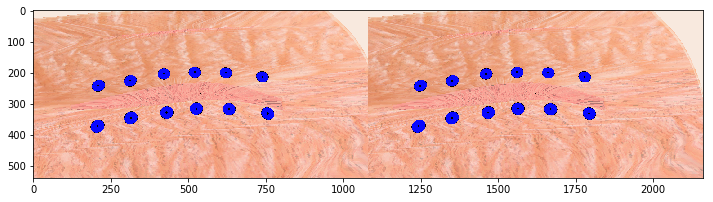

In [53]:
import image_geometry
utils = None
import utils
stereo_model = image_geometry.StereoCameraModel()
stereo_model.fromCameraInfo(left_camera_info, right_camera_info)

tf_cam_to_world = utils.tf_to_pykdl_frame(tf_listener.lookupTransform('simworld', 'simcamera', rospy.Time()))
tf_world_to_psm1 = \
    utils.tf_to_pykdl_frame(tf_listener.lookupTransform('PSM1_base', 'simworld', rospy.Time()))
tf_world_to_psm2 = \
    utils.tf_to_pykdl_frame(tf_listener.lookupTransform('PSM2_base', 'simworld', rospy.Time()))
tf_world_to_psm3 = \
    utils.tf_to_pykdl_frame(tf_listener.lookupTransform('PSM3_base', 'simworld', rospy.Time()))

objects, frame = utils.get_points_and_img(left_image_msg, right_image_msg, stereo_model, tf_cam_to_world)
plt.figure(figsize=(12, 5))
plt.imshow(frame)
for o in objects:
    o = PyKDL.Vector(o.x(), o.y(), o.z())
#     o = PyKDL.Vector(o.x(), o.y(), o.z())

In [11]:
len(objects)

12

In [44]:
# pair up points that are across from each other
# x is *more or less* the axis along the wound
paired_pts = []
while objects:
    pt = objects[0]
    objects.remove(pt)
#     pt2 = min(objects, key=lambda obj : abs(obj.x() - pt.x()))
    pt2 = min(objects, key=lambda obj : abs(obj.y() - pt.y()))
    objects.remove(pt2)
#     paired_pts.append(
#         (max(pt, pt2, key=lambda p: p.y()), min(pt, pt2, key=lambda p: p.y())))
    paired_pts.append(
        (max(pt, pt2, key=lambda p: p.x()), min(pt, pt2, key=lambda p: p.x())))

z_val = paired_pts[0][0][2]
print(len(paired_pts)*2-1)
for i in range(len(paired_pts)):
    paired_pts[i][0][2] = z_val
    paired_pts[i][1][2] = z_val
    
print(paired_pts[0][0][1])
print(paired_pts[1][0][1])
paired_pts = sorted(paired_pts,key=lambda p: float(p[0][1]))
print("paired points sorted:")
paired_pts

11
0.0361846714651
0.0238355879146
paired points sorted:


[([    -1.51471,  -0.0274779,    0.647441],
  [    -1.53048,  -0.0260764,    0.647441]),
 ([    -1.51178,  -0.0133016,    0.647441],
  [    -1.52672,  -0.0124818,    0.647441]),
 ([     -1.5103, -0.00119681,    0.647441],
  [    -1.52536,-0.000352323,    0.647441]),
 ([     -1.5096,   0.0109787,    0.647441],
  [    -1.52548,   0.0108618,    0.647441]),
 ([    -1.51195,   0.0238356,    0.647441],
  [    -1.52676,   0.0238808,    0.647441]),
 ([    -1.51242,   0.0361847,    0.647441],
  [    -1.52899,   0.0356307,    0.647441])]

In [54]:
import suturing_state_machine
# from importlib import reload
reload(suturing_state_machine)
reload(utils)
import time

# print(pts_psm1)
# pts_psm1 =  [( [  -1.53043,  -0.0261386,    0.648708],[    -1.51484,  -0.0273296,    0.648708])]
# print(pts_psm1)

pts_psm1 = paired_pts[:2]
pts_psm2 = paired_pts[4:]
pts_psm3 = paired_pts[2:4]

# double PSM same dir
# sm1 = suturing_state_machine.SuturingStateMachine(psm1, tf_world_to_psm1, pts_psm1, arm_name = 'PSM1')  
# sm2 = suturing_state_machine.SuturingStateMachine(psm2, tf_world_to_psm2, pts_psm2, arm_name = 'PSM2')

# start_time = time.clock()
# while not sm1.is_done() or not sm2.is_done():
#     sm1.run_once()
#     sm2.run_once()
#     time.sleep(0.1)
    
# completion_time = time.clock() - start_time
# print("completion time(s): ",completion_time)

# single PSM 
# pts_psm2 = paired_pts

# sm2 = suturing_state_machine.SuturingStateMachine(psm2, tf_world_to_psm2, pts_psm2, arm_name = 'PSM2')

start_time = time.clock()
# while not sm2.is_done():
#     sm2.run_once()
#     time.sleep(0.1)

# double PSM opposite dir
sm1 = suturing_state_machine.SuturingStateMachine(psm1, tf_world_to_psm1, pts_psm1, arm_name = 'PSM3')  
sm2 = suturing_state_machine.SuturingStateMachine(psm2, tf_world_to_psm2, pts_psm2, arm_name = 'PSM2')
sm3 = suturing_state_machine.SuturingStateMachine(psm3, tf_world_to_psm3, pts_psm3, arm_name = 'PSM3')

while not sm1.is_done() or not sm2.is_done() or not sm3.is_done():
    sm1.run_once()
    sm2.run_once()
    sm3.run_once()
    time.sleep(0.1)
    
completion_time = time.clock() - start_time
print("completion time(s): ",completion_time)

completion time(s):  36.959478


In [ ]:
dir(psm1)

In [ ]:
ecm.get_current_joint_position()

In [ ]:
psm2.close_jaw()

In [ ]:
#random angle for skin generator
	
# generate random floating point values
from random import seed
from random import random
# seed random number generator
seed(1)
# generate random numbers between 0-1
num_trials = 30
lowerbound_angle = -10
upperbound_angle = 10
for _ in range(num_trials):
	value = (random()*(upperbound_angle-lowerbound_angle))+lowerbound_angle
	print(value)